## Preparing

In [1]:
!git init .
!git remote add -f origin "https://github.com/Sankek/DenoisingDiffusion"
!git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 11), reused 22 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
From https://github.com/Sankek/DenoisingDiffusion
 * [new branch]      master     -> origin/master
From https://github.com/Sankek/DenoisingDiffusion
 * branch            master     -> FETCH_HEAD


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# unpacking archive with open ImageNet 64x64 images 
# images_ext = 'png'
# !tar -xf "/content/drive/MyDrive/Projects/ImageInpainting/dataset/train_64x64.tar" > /dev/null
# !mv train_64x64 train_set

# CelebA
# images_ext = 'jpg'
!unzip "/content/drive/MyDrive/Projects/DenoisingDiffusion/dataset/CelebA.zip" > /dev/null
!mv CelebA train_set

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

## Go

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from data import DiffusionDataset
from model import DiffusionNet
from utils import save_state, load_state, tensor2image
from train import train

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Tue Aug  2 08:57:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
batch_size = 24
image_size = 128

dataset_mean = [0.5]*3 
dataset_std = [0.5]*3 
dataset = DiffusionDataset('train_set', dataset_mean=dataset_mean, dataset_std=dataset_std, ext='jpg')
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

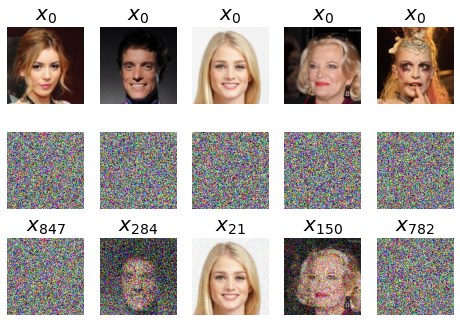

In [ ]:
def plot_examples():
    fig, axs = plt.subplots(3, 5, figsize=(8, 5.5))
    for col in range(5):
        noised_img, t, noise = dataset[col]
        alpha_prod_sqrt = dataset.variance_schedule.alpha_prod_sqrt[t]
        alpha_prod_inv_sqrt = dataset.variance_schedule.alpha_prod_inv_sqrt[t]
        original_img = 1/alpha_prod_sqrt * (noised_img - alpha_prod_inv_sqrt*noise)
        
        for i, im in enumerate([original_img, noise, noised_img]):
            axs[i, col].imshow(tensor2image(im, dataset_mean, dataset_std))
            axs[i, col].axis('off')
        axs[0, col].set_title(f'$x_0$', fontsize=20)
        axs[2, col].set_title(f'$x_{{{t}}}$', fontsize=20)
        
    plt.show()
plot_examples()

In [10]:
!pip install denoising_diffusion_pytorch

from denoising_diffusion_pytorch import Unet
model = Unet(
    dim = 64,    dim_mults = (1, 2, 4, 8)
).to(DEVICE)

In [11]:
lr = 2e-4

# model = DiffusionNet().to(DEVICE)
trained_iters=0
save_folder = '/content/drive/MyDrive/Projects/DenoisingDiffusion/saved'

prev_state = load_state(save_folder, 'ddp_CelebA_gradaccum25_5115621')
model = prev_state['model']
model.load_state_dict(prev_state['model_state'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = prev_state['optimizer'] # issue
optimizer.load_state_dict(prev_state['optimizer_state'])
trained_iters = prev_state['trained_iters']

criterion = MSELoss()

save_name ='ddp_CelebA_gradaccum25'

In [ ]:
# 3400002 lr2e-4 -> 1e-4
# 4914021 lr1e-4 -> 5e-5

In [ ]:
for p in optimizer.param_groups:
    p['lr'] = 5e-5

In [13]:
for p in optimizer.param_groups:
    print(p['lr'])

5e-05


In [ ]:
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  36255235


## Training

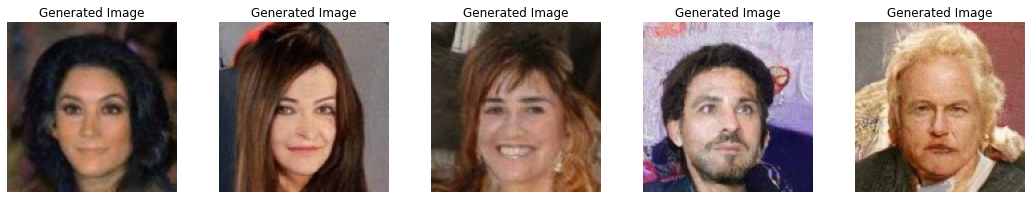

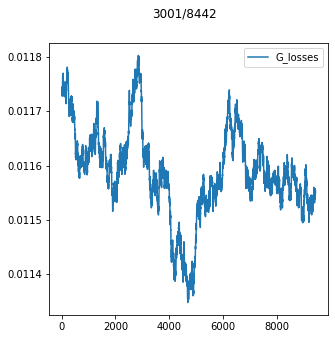

In [ ]:
losses = train(
    model, optimizer, dataloader, criterion, dataset.variance_schedule, dataset_mean, dataset_std, 
    epochs=1000, device=DEVICE, trained_iters=trained_iters, save_folder=save_folder, 
    save_name=save_name, save_interval=25200, losses_smooth_window=2000, graph_show_interval=500,
    grad_accum=25
)